In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/u/jai/efficiency/src")
from src.efficiency import *
from scipy.stats import ttest_rel, ttest_ind


# Helper functions

## Global Variables

In [2]:
ASKREDDIT_COLOR = "#FF9E45" 
UNIFORM_COLOR = "#72D6B7"
HYPOTHETICAL_COLOR = "black"
COMMUNITY_SPECIFIC_COLOR = "#AC98E0"
DEFAULT_COLOR = "blue"

color_dict = {
    "uniform": UNIFORM_COLOR,
    "askreddit": ASKREDDIT_COLOR,
    "hypothetical": HYPOTHETICAL_COLOR,
    "community_specific": COMMUNITY_SPECIFIC_COLOR
}

## Core Functions

In [3]:
def split_rank_df(rank_df):
    attested = rank_df[~rank_df['name'].str.startswith("gaussian")]
    hypothetical = rank_df[rank_df['name'].str.startswith("gaussian")]
    return attested, hypothetical


def augment_data(need_to_ranks, need):
    rank_df = need_to_ranks[need]
    attested, hypothetical = split_rank_df(rank_df)
    attested_dict = {"rank_df": attested, "color": color_dict.get(need, DEFAULT_COLOR)}
    hypothetical_dict = {"rank_df": hypothetical, "color": color_dict.get("hypothetical")}
    return {"attested": attested_dict, "hypothetical": hypothetical_dict}


def load_data():
    rank_data_dir = f"cogsci_2024_efficiency_scores/" #"/ais/hal9000/datasets/reddit/stance_pipeline/classifiers/"
    completed_needs = [need[:-4] for need in os.listdir(DATA_OUT_DIR + rank_data_dir)] # We strip the .pkl characters at the end
    need_to_ranks = {need: Serialization.load_obj(rank_data_dir + need) for need in completed_needs}
    
    need_to_dict = {}
    for need in need_to_ranks:
        need_to_dict[need] = augment_data(need_to_ranks, need)
    return need_to_dict


def compute_cohens_d(arr_1, arr_2):
    numerator = np.mean(arr_1) - np.mean(arr_2)
    denominator = np.sqrt((np.std(arr_1) ** 2 + np.std(arr_2) ** 2)/2)
    return np.round(numerator/denominator, 2)

## Visualization Functions

In [4]:
def visualize_single_need(data, need, xlims=[0, 20], ylims=[0, 8.1]):
    labels = ['hypothetical', 'attested']
    xs = [data[need][label]['rank_df']['complexity'] for label in labels]
    ys = [data[need][label]['rank_df']['cost'] for label in labels]
    colors = [data[need][label]['color'] for label in labels]
    # title = f"Complexity/Cost Tradeoff using {need.capitalize()} Needs"
    title = ""
    plot_efficiency(xs, ys, labels, colors, title, xlims, ylims)


def visualize_two_needs(data, need_1, need_2, xlims=[0, 6.3], ylims=[5, 8.1]):
    labels = [need_1, need_2]
    xs = [data[label]['attested']['rank_df']['complexity'] for label in labels]
    ys = [data[label]['attested']['rank_df']['cost'] for label in labels]
    colors = [data[label]['attested']['color'] for label in labels]
    title = ""#f"Complexity/Cost Tradeoff \n({need_1.capitalize()} Needs vs. {need_2.capitalize()} Needs)"
    
    need_to_title = {
        "uniform": "Uniform",
        "askreddit": "Reddit-General",
        "community_specific": "Community Specific"
    }

    labels = [need_to_title[label] for label in labels]
    plot_efficiency(xs, ys, labels, colors, title, xlims, ylims)


def plot_efficiency(xs, ys, labels, colors, title, xlims, ylims):
    # plt.rcParams["figure.figsize"] = (6,4)
    # plt.rcParams["font.size"] = 20
    plt.figure(figsize=(6, 4), dpi=80)
    for x, y, label, color in zip(xs, ys, labels, colors):
        plt.scatter(x, y, label=label.title(), color=color, alpha=1)
    plt.title(title, fontdict={"size": 20})
    plt.legend()
    plt.xlabel("Complexity", fontdict={"size": 20})
    plt.ylabel("Communicative Cost", fontdict={"size": 20})
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(ylims[0], ylims[1])
    plt.tight_layout()
    plt.show()



# def joint_density_plot(data):
#     plt.rcParams.update({"font.size": 14})
#     x = sns.jointplot(data=data, x='complexity', y='cost', alpha=0.5)
#     x.fig.suptitle("Complexity-Cost Space using \nLog-Spaced Grid Search")
#     x.fig.subplots_adjust(top=0.85)
#     plt.xlabel('X', fontsize=18)
#     plt.ylabel('Y', fontsize=18)
#     plt.ylim(0, 8)
#     plt.show()
#     plt.clf()

In [15]:
def compare_ranks(data_dict_1, data_dict_2, title, test_type='ind', alpha_val=1):
    ranks_1 = data_dict_1['rank_df']['true_rank'].tolist()
    ranks_2 = data_dict_2['rank_df']['true_rank'].tolist()
    
    plt.rcParams["figure.figsize"] = (14,10)
    plt.rcParams["font.size"] = 40
    plt.hist(ranks_1, label=data_dict_1['label'], color=data_dict_1['color'], alpha=alpha_val, density=1, bins=np.arange(10, 150, 5))
    plt.hist(ranks_2, label=data_dict_2['label'], color=data_dict_2['color'], alpha=0.7, density=1, bins=np.arange(10, 150, 5))
    # sns.kdeplot(ranks_1, label=data_dict_1['label'], color=data_dict_1['color'])
    # sns.kdeplot(ranks_2, label=data_dict_2['label'], color=data_dict_2['color'])
    plt.xlabel("Non-Dominated Rank", fontdict={"size": 40})
    plt.ylabel("Density", fontdict={"size": 40}, labelpad=10)
    plt.title(title, fontdict={"size": 40})
    plt.legend()
    plt.show()
    plt.clf()

    if test_type == 'ind':
        print(np.mean(ranks_2))
        print(np.mean(ranks_1))
        print(ttest_ind(ranks_2, ranks_1))
        print(compute_cohens_d(ranks_2, ranks_1))
    else:
        ranks_1 = data_dict_1['rank_df']['true_rank']
        ranks_2 = data_dict_2['rank_df']['true_rank']

        ranks_2 = ranks_2.loc[ranks_1.index]

        ranks_1 = ranks_1.tolist()
        ranks_2 = ranks_2.tolist()
        print(np.mean(ranks_2))
        print(np.mean(ranks_1))
        print(ttest_rel(ranks_2, ranks_1))
        print(compute_cohens_d(np.array(ranks_2)-np.array(ranks_1), np.zeros(len(ranks_1))))

    # print(compute_cohens_d(ranks_2, ranks_1))

    
def compare_to_hypotheticals(data, need):

    # title = f"Pareto Efficiency using \n({need.capitalize()} Needs)"
    title = ""

    data_dict_1 = {"rank_df": data[need]['hypothetical']['rank_df'], "label": "Hypothetical", "color": data[need]['hypothetical']['color']}
    data_dict_2 = {"rank_df": data[need]['attested']['rank_df'], "label": "Attested", "color": data[need]['attested']['color']}

    compare_ranks(data_dict_1, data_dict_2, title)


def compare_two_rank_dfs(data, need_1, need_2, test_type='rel', alpha=1):
    title = ""#f"Comparing Pareto Efficiency \n({need_1.capitalize()} Needs vs. {need_2.capitalize()} Needs)"
    need_to_title = {
        "uniform": "Uniform",
        "askreddit": "Reddit-General",
        "community_specific": "Community Specific"
    }
    data_dict_1 = {"rank_df": data[need_1]['attested']['rank_df'], "label": need_to_title[need_1], "color": data[need_1]['attested']['color']}
    data_dict_2 = {"rank_df": data[need_2]['attested']['rank_df'], "label": need_to_title[need_2], "color": data[need_2]['attested']['color']}

    compare_ranks(data_dict_1, data_dict_2, title, test_type=test_type, alpha_val=alpha)



def compare_three_rank_dfs(data, need_1, need_2, need_3, test_type='rel', alpha=1, bins=np.arange(10, 80, 5)):
    title = ""#f"Comparing Pareto Efficiency \n({need_1.capitalize()} Needs vs. {need_2.capitalize()} Needs)"
    need_to_title = {
        "uniform": "Uniform",
        "askreddit": "Reddit-General",
        "community_specific": "Community Specific"
    }
    data_dict_1 = {"rank_df": data[need_1]['attested']['rank_df'], "label": need_to_title[need_1], "color": data[need_1]['attested']['color']}
    data_dict_2 = {"rank_df": data[need_2]['attested']['rank_df'], "label": need_to_title[need_2], "color": data[need_2]['attested']['color']}
    if need_3 != 'hypothetical':
        data_dict_3 = {"rank_df": data[need_3]['attested']['rank_df'], "label": need_to_title[need_3], "color": data[need_3]['attested']['color']}
    else:
        data_dict_3 = {"rank_df": data[need_1]['hypothetical']['rank_df'], "label": "Hypotheticals", "color": data[need_1]['hypothetical']['color']}



    ranks_1 = data_dict_1['rank_df']['true_rank'].tolist()
    ranks_2 = data_dict_2['rank_df']['true_rank'].tolist()
    ranks_3 = data_dict_3['rank_df']['true_rank'].tolist()
    
    plt.hist(ranks_1, label=data_dict_1['label'], color=data_dict_1['color'], density=True, alpha=alpha, bins=bins)
    plt.hist(ranks_2, label=data_dict_2['label'], color=data_dict_2['color'], density=True, alpha=alpha, bins=bins)
    plt.hist(ranks_3, label=data_dict_3['label'], color=data_dict_3['color'], density=True, alpha=alpha, bins=bins)

    # sns.kdeplot(ranks_1, label=data_dict_1['label'], color=data_dict_1['color'])
    # sns.kdeplot(ranks_2, label=data_dict_2['label'], color=data_dict_2['color'])
    plt.xlabel("Non-Dominated Rank", fontdict={"size": 16})
    plt.ylabel("Frequency", fontdict={"size": 16})
    plt.title(title, fontdict={"size": 16})
    plt.legend()
    plt.show()
    plt.clf()

# Loading Data

In [6]:
# Takes 10 seconds
all_data = load_data()

In [28]:
a = all_data['askreddit']['attested']['rank_df'].sort_values(by='complexity').head(-4)
spearmanr(a['cost'], a['complexity'])

SpearmanrResult(correlation=-0.8496239976408227, pvalue=0.0)

# Pre-analysis: Visualizing Hypotheticals

In [7]:
def joint_density_plot(data):
    plt.rcParams.update({"font.size": 14})
    x = sns.jointplot(data=data, x='complexity', y='cost', alpha=0.5)
    x.fig.suptitle("Complexity-Cost Space using \nLog-Spaced Grid Search")
    x.fig.subplots_adjust(top=0.85)
    plt.xlabel('X', fontsize=18)
    plt.ylabel('Y', fontsize=18)
    plt.show()
    plt.clf()

# RQ1: Evaluating Efficiency wrt Uniform Needs

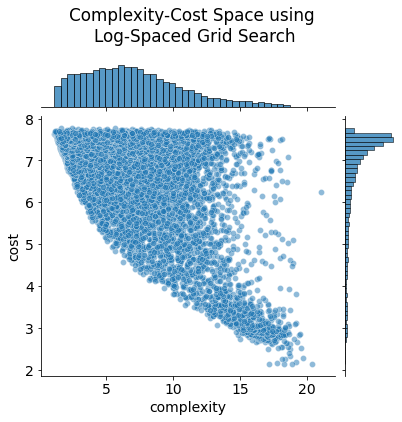

<Figure size 432x288 with 0 Axes>

In [8]:
joint_density_plot(all_data['uniform']['hypothetical']['rank_df'])

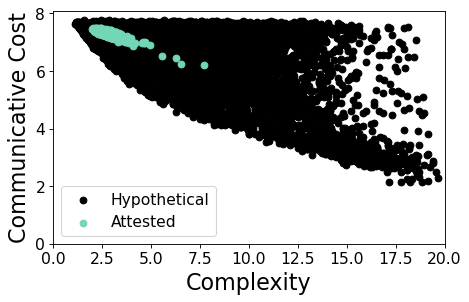

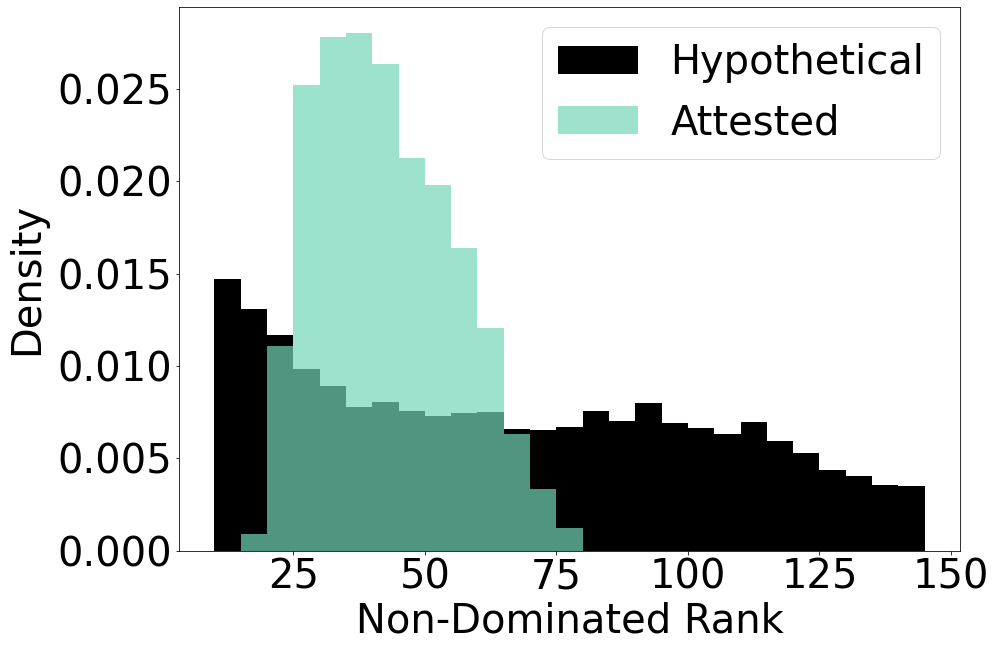

Ttest_indResult(statistic=-18.438084122049144, pvalue=7.109096413717333e-75)
-0.57


<Figure size 1008x720 with 0 Axes>

In [9]:
# TODO XXX: Swap out placeholder community for 'uniform'
visualize_single_need(all_data, "uniform")
compare_to_hypotheticals(all_data, "uniform")

In [10]:
# Compare to restricted set
def controlled_analysis(data, need, control_dim):

    # Get maximum value in one dimension
    attested_df = data[need]['attested']['rank_df']
    max_dim_value = attested_df[control_dim].max()

    # Get subset of hypotheticals
    hypothetical_df = data[need]['hypothetical']['rank_df']
    hypothetical_subset = hypothetical_df[hypothetical_df[control_dim] <= max_dim_value]

    print(f"# Hypotheticals (all): {hypothetical_df.shape[0]}")
    print(f"# Hypotheticals (subset): {hypothetical_subset.shape[0]}")

    new_data = {need: {"attested": {"rank_df": attested_df, "color": data[need]['attested']['color']},
                       "hypothetical": {"rank_df": hypothetical_subset, "color": "orange"}
                       }
                }
    
    if control_dim == "complexity":
        x_max = max_dim_value + 0.5
        y_min = hypothetical_subset['cost'].min() - 0.5
    else:
        x_max = hypothetical_subset['complexity'].max()
        y_min = 4 # TODO: CHANGE WHEN WE FIGURE OUT COST ANALYSIS

    joint_density_plot(hypothetical_subset)
    visualize_single_need(new_data, need, xlims=[0, x_max], ylims=[y_min, 8.1])
    compare_to_hypotheticals(new_data, need)


# Hypotheticals (all): 10000
# Hypotheticals (subset): 6143


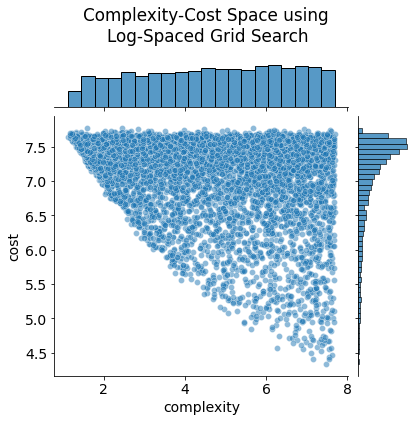

<Figure size 1008x720 with 0 Axes>

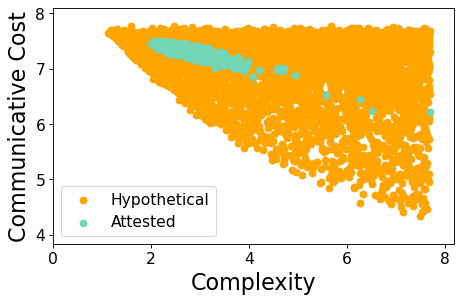

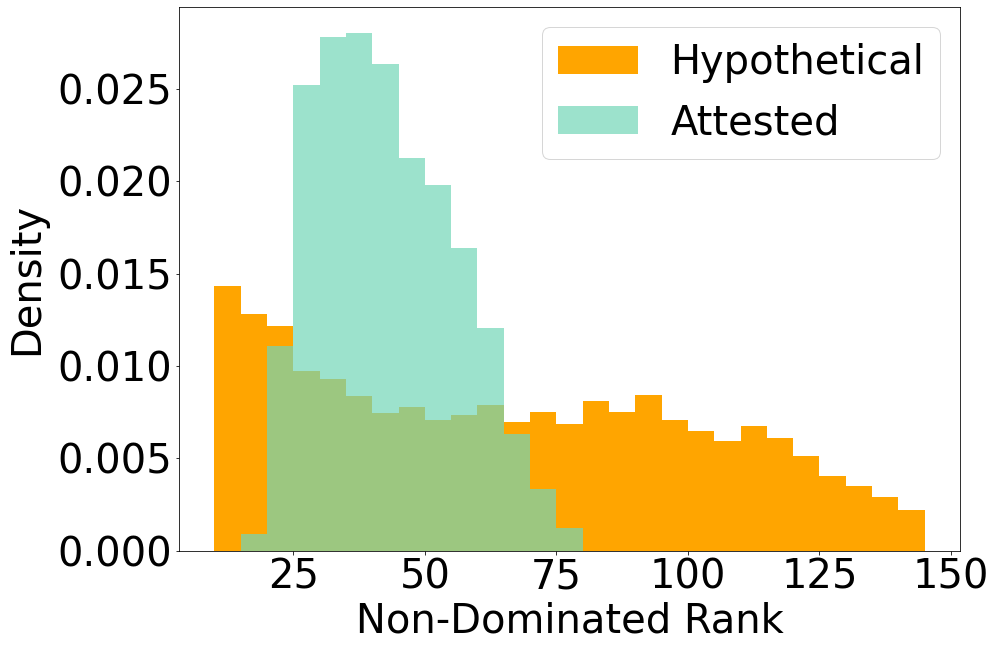

Ttest_indResult(statistic=-15.667937880814053, pvalue=1.586442264346602e-54)
-0.49


<Figure size 1008x720 with 0 Axes>

In [11]:
controlled_analysis(all_data, "uniform", "complexity")

# RQ2: Comparing Across Need Probabilities

## Comparing Uniform to AskReddit Needs

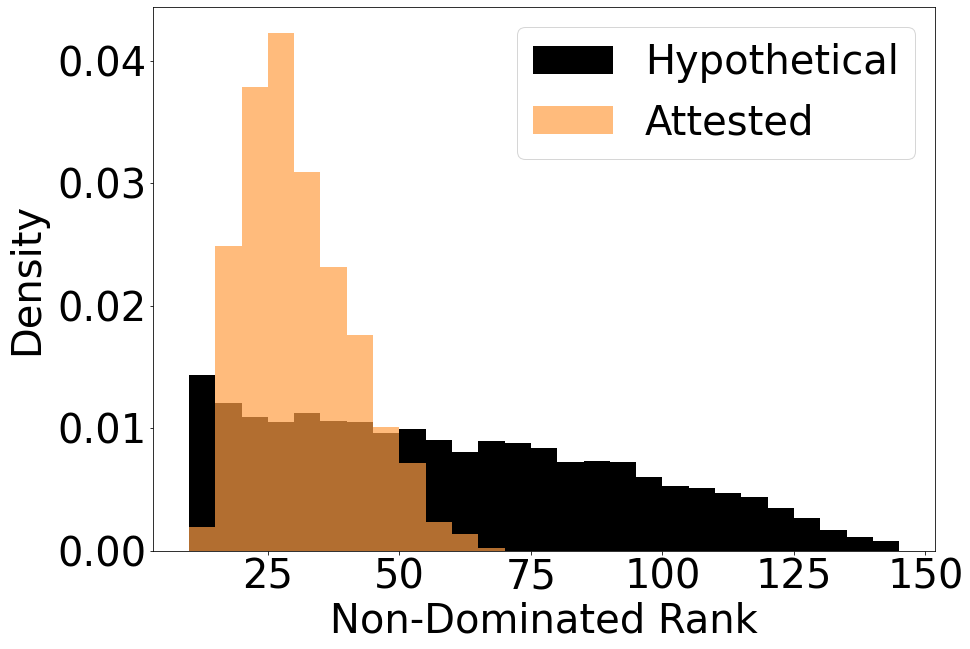

30.42731048805815
52.0285
Ttest_indResult(statistic=-25.92731122483511, pvalue=3.117384299722496e-144)
-0.81


<Figure size 1008x720 with 0 Axes>

In [16]:
# visualize_single_need(all_data, "askreddit")
compare_to_hypotheticals(all_data, "askreddit")
# controlled_analysis(all_data, "askreddit", "complexity")

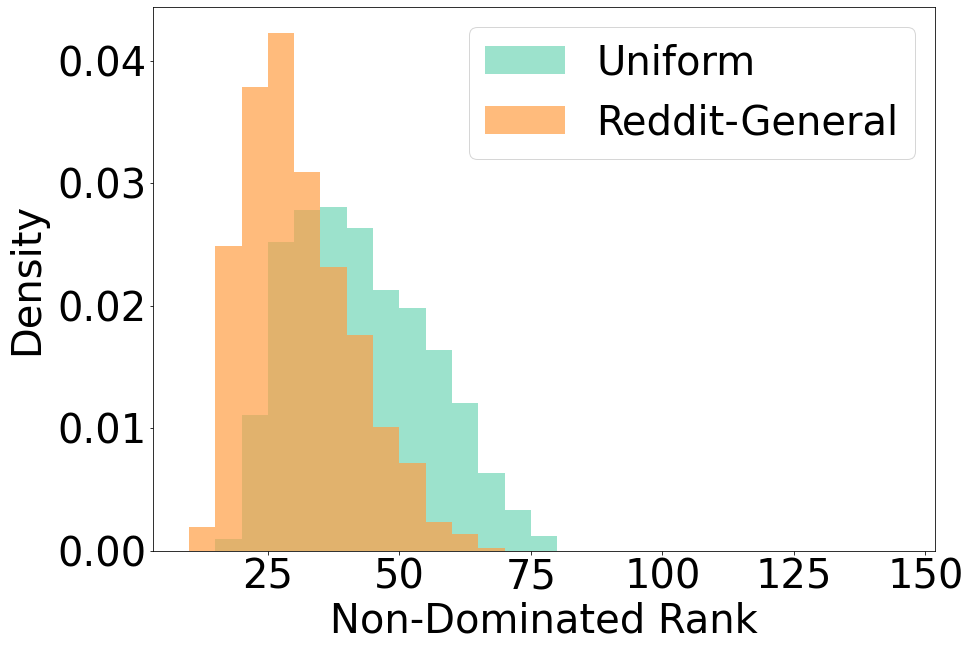

Ttest_relResult(statistic=-48.612041073849085, pvalue=0.0)
-1.57


<Figure size 1008x720 with 0 Axes>

In [13]:

k_dfs(all_data, 'uniform', 'askreddit', test_type='paired', alpha=0.7)

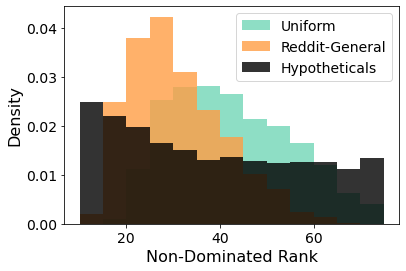

<Figure size 432x288 with 0 Axes>

In [42]:
compare_three_rank_dfs(all_data, 'uniform', 'askreddit', "hypothetical", test_type='paired', alpha=0.8)

## Comparing to Community-Specific Needs

In [19]:
def extract_community_specific_ranks(data):
    rows = []
    for need in tqdm(data):
        if need not in ['uniform', 'askreddit']:
            rows.append(data[need]['attested']['rank_df'].loc[need])
    return pd.concat(rows, axis=1).T

In [20]:
community_specific_ranks = extract_community_specific_ranks(all_data)
all_data['community_specific'] = {"attested": {"rank_df": community_specific_ranks, "color": COMMUNITY_SPECIFIC_COLOR}}

100%|██████████| 1928/1928 [00:00<00:00, 2142.92it/s]


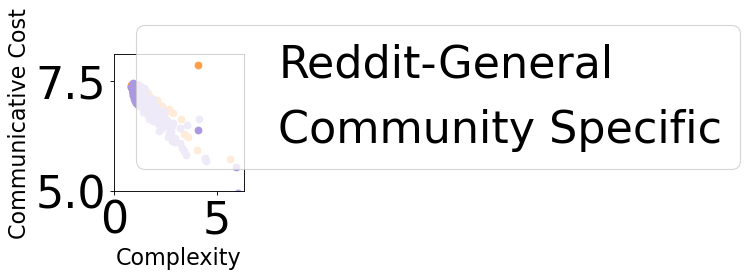

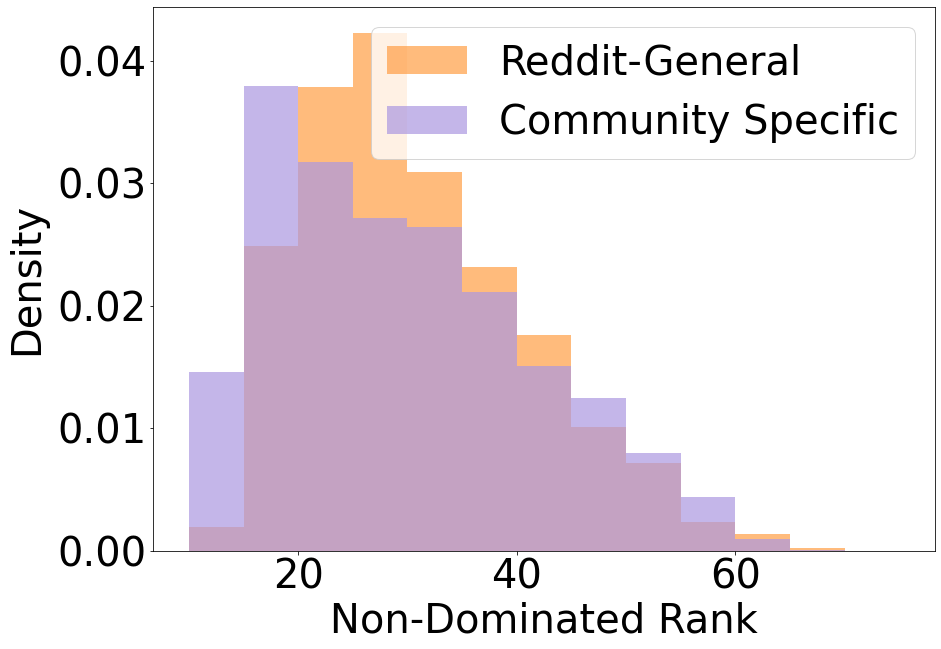

Ttest_relResult(statistic=-5.273583883669151, pvalue=1.4882851551990276e-07)
-0.17


<Figure size 1008x720 with 0 Axes>

In [21]:
visualize_two_needs(all_data, "askreddit", "community_specific")
compare_two_rank_dfs(all_data, "askreddit", "community_specific", test_type="paired", alpha=0.7)

## Which need probability is each community most efficient for?

In [24]:
def combine_attested_values(data):
    columns = {}
    for need_dist in data:
        if need_dist == 'community_specific':
            continue
        curr_data = data[need_dist]['attested']['rank_df']['true_rank']
        columns[need_dist] = curr_data
    return pd.DataFrame(columns)

def combine_hypothetical_values(data):
    columns = {}
    for need_dist in data:
        if need_dist == 'community_specific':
            continue
        curr_data = data[need_dist]['hypothetical']['rank_df']['true_rank']
        columns[need_dist] = curr_data
    return pd.DataFrame(columns)

# columns are for each need distribution, rows are encoders
all_attested_ranks = combine_attested_values(all_data)
all_hypothetical_ranks = combine_hypothetical_values(all_data)
all_ranks = pd.concat((all_attested_ranks, all_hypothetical_ranks))
all_ranks_sorted = all_ranks[all_attested_ranks.index]

# RQ3

In [25]:
# what proportion of communities are in the top X% for their own need?
com_to_percentile = {}
for com in all_ranks_sorted.columns:
    column = all_ranks_sorted[com].sort_values()
    own_rank = column[com]
    num_better = column[column < own_rank].shape[0]
    com_to_percentile[com] = num_better / len(column)
percentile_df = pd.DataFrame.from_dict(com_to_percentile, orient='index')
percentile_df.columns = ['percentile']

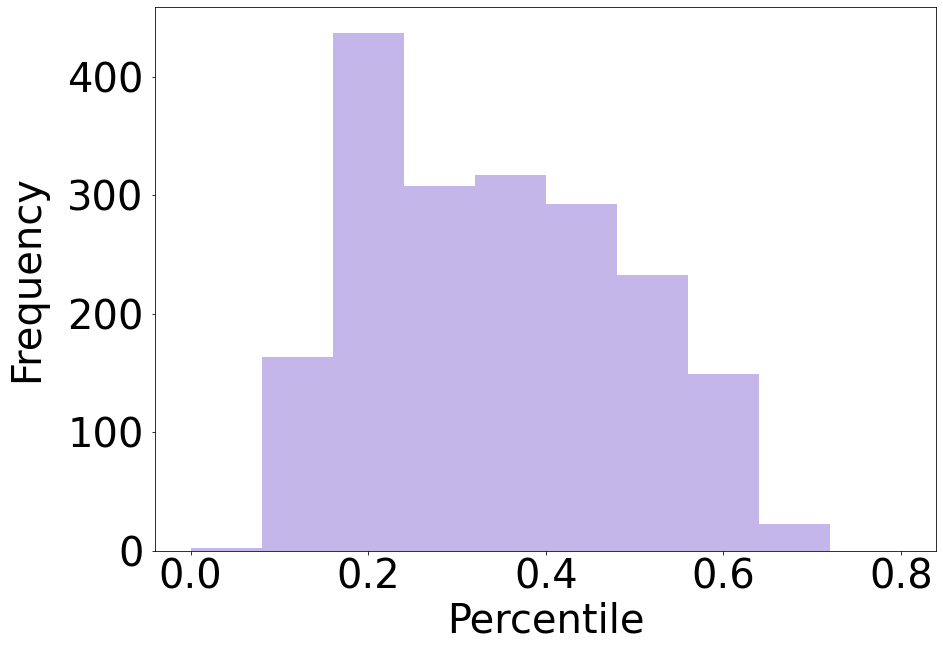

<Figure size 1008x720 with 0 Axes>

In [30]:
plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams["font.size"] = 40
plt.rcParams['ytick.major.pad']= 8
counts, bins, hist_plot= plt.hist(percentile_df['percentile'], bins=np.linspace(0, 0.8, 11), color=COMMUNITY_SPECIFIC_COLOR, alpha=0.7)
plt.xlabel("Percentile")
plt.ylabel("Frequency", labelpad=20)
# plt.legend()
plt.show()
plt.clf()


In [55]:
# Controlled Analysis
com_to_controlled_hypotheticals = {}
for com in all_ranks_sorted.columns:
    curr_attested = all_data[com]['attested']['rank_df']
    curr_hypotheticals = all_data[com]['hypothetical']['rank_df']
    max_attested_complexity = curr_attested['complexity'].max()
    hypothetical_subset = curr_hypotheticals[curr_hypotheticals['complexity'] <= max_attested_complexity]
    com_to_controlled_hypotheticals[com] = hypothetical_subset.index.tolist()

In [56]:
# what proportion of communities are in the top X% for their own need?
com_to_controlled_percentile = {}
com_to_controlled_num = {}
for com in all_ranks_sorted.columns:
    column = all_ranks_sorted[com].sort_values()
    own_rank = column[com]

    valid_communities = all_ranks_sorted.columns.tolist() + com_to_controlled_hypotheticals[com]
    com_to_controlled_num[com] = len(valid_communities)
    controlled_column = column.loc[valid_communities]
    num_better = controlled_column[controlled_column < own_rank].shape[0]
    com_to_controlled_percentile[com] = num_better / len(controlled_column)
controlled_percentile_df = pd.DataFrame.from_dict(com_to_controlled_percentile, orient='index')
controlled_percentile_df.columns = ['controlled_percentile']

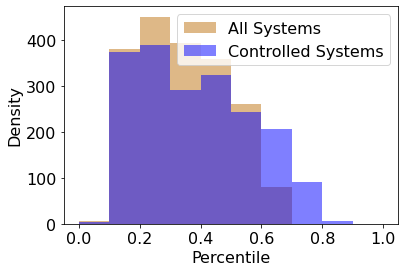

In [57]:
plt.rcParams.update({"font.size": 16})
counts, bins, hist_plot= plt.hist(percentile_df['percentile'], bins=np.linspace(0, 1, 11), color="burlywood", label=f"All Systems", alpha=1)
counts, bins, hist_plot= plt.hist(controlled_percentile_df['controlled_percentile'], bins=np.linspace(0, 1, 11), color="blue", label=f"Controlled Systems", alpha=0.5)
# sns.kdeplot(percentile_df['percentile'], color="burlywood", label="All Systems")
# sns.kdeplot(controlled_percentile_df['controlled_percentile'], color="blue", label="Controlled Analysis")

plt.xlabel("Percentile")
plt.ylabel("Density")
plt.legend()

In [29]:
# # what proportion of communities are in the top X% for their own need?
# com_to_attested_percentile = {}
# for com in all_attested_ranks.index:
#     column = all_attested_ranks[com].sort_values()
#     # print(column.shape)
#     own_rank = column[com]
#     num_better = column[column < own_rank].shape[0]
#     com_to_attested_percentile[com] = num_better / len(column)
# attested_percentile_df = pd.DataFrame.from_dict(com_to_attested_percentile, orient='index')
# attested_percentile_df.columns = ['percentile']

In [1]:
# plt.rcParams.update({"font.size": 16})
# # counts, bins, hist_plot= plt.hist(percentile_df['percentile'], bins=np.linspace(0, 1, 11), color="burlywood")
# # counts, bins, hist_plot= plt.hist(attested_percentile_df['percentile'], bins=np.linspace(0, 1, 11), color="blue")
# sns.kdeplot(percentile_df['percentile'], color="burlywood", label="All Systems")
# sns.kdeplot(attested_percentile_df['percentile'], color="blue", label="Attested Systems")

# plt.xlabel("Percentile")
# plt.ylabel("Density")
# plt.legend()

In [75]:
# all_percentile_df = pd.concat((percentile_df, controlled_percentile_df), axis=1)
# all_percentile_df['diff'] = all_percentile_df['controlled_percentile'] - all_percentile_df['percentile']

# Social Factors Analysis

In [81]:
contact_info = pd.read_csv("/ais/hal9000/datasets/reddit/stance_pipeline/cogsci_2024/network_analysis/cogsci_2024_social_network_features.csv", index_col=0)
size_info = pd.read_csv("/u/jai/efficiency/data/size_cogsci_2024_social_network_features.csv",  index_col=0)
social_network_info = pd.read_csv("/u/jai/efficiency/data/final_cogsci_2024_social_network_features.csv",  index_col=0)
social_network_info['size'] = size_info['size']
social_network_info['contact'] = 1 - contact_info['contact']
social_network_info.index = social_network_info.index.str.lower()



In [82]:
# Compute complexity/cost relative to native need distribution
complexities = []
costs = []
corrs = []
for com in percentile_df.index:
    native_df = all_data[com]['attested']['rank_df']
    native_dist = native_df.loc[com]
    # corrs.append(spearmanr(native_df['complexity'].loc[full_social_df.index], native_df['cost'].loc[full_social_df.index])[0])
    complexities.append(native_dist['complexity'])
    costs.append(native_dist['cost'])
percentile_df['complexity'] = complexities
percentile_df['cost'] = costs
percentile_df['percentile'] = 1-percentile_df['percentile']

In [84]:
full_social_df = social_network_info.join(percentile_df).dropna()

In [90]:
full_social_df.sort_values(by='cost')

,size,loyalty,density,contact,percentile,complexity,cost
picturegame,2572,0.099010,0.004559,0.395639,0.760859,11.270166,2.155954
deepfriedmemes,41155,0.003582,0.000147,0.343008,0.693107,8.245082,3.609452
photoshopbattles,33219,0.019210,0.000148,0.364471,0.648499,10.322569,3.693127
hmmm,108486,0.002775,0.000062,0.288939,0.567835,7.118200,4.840865
sexsells,5641,0.123221,0.002938,0.234086,0.877830,6.033002,4.943820
...,...,...,...,...,...,...,...
waiting_to_try,2464,0.055690,0.007745,0.378724,0.546872,1.217359,7.410273
gamestop,8330,0.097373,0.002259,0.348022,0.861731,0.916191,7.412967
flipping,15957,0.038573,0.001094,0.346556,0.838169,0.947943,7.413380
bestbuy,10983,0.145973,0.002480,0.377880,0.872715,0.908814,7.433589


In [133]:
SIG_LEVEL = 0.05/12

In [131]:
full_social_df.corr("spearman").loc[['complexity', 'cost', 'percentile']][['complexity', 'cost', 'percentile']].round(2)

,complexity,cost,percentile
complexity,1.00,-0.72,-0.58
cost,-0.72,1.00,0.24
percentile,-0.58,0.24,1.00


In [134]:
social_factors = ['size', 'density', 'contact']
for factor in social_factors:
    percentile_corr = spearmanr(full_social_df[factor], full_social_df['percentile'])
    complexity_corr = spearmanr(full_social_df[factor], full_social_df['complexity'])
    cost_corr = spearmanr(full_social_df[factor], full_social_df['cost'])

    print(factor)
    print(f"Percentile\n Corr: {np.round(percentile_corr[0], 2)}, Sig = {np.round(percentile_corr[1], 3)}, Is_Sig = {percentile_corr[1]<=SIG_LEVEL}")
    print(f"Complexity\n Corr: {np.round(complexity_corr[0], 2)}, Sig = {np.round(complexity_corr[1], 3)}, Is_Sig = {complexity_corr[1]<=SIG_LEVEL}")
    print(f"Cost\n Corr: {np.round(cost_corr[0], 2)}, Sig = {np.round(cost_corr[1], 3)}, Is_Sig = {cost_corr[1]<=SIG_LEVEL}")




size
Percentile
 Corr: 0.18, Sig = 0.0, Is_Sig = True
Complexity
 Corr: -0.08, Sig = 0.0, Is_Sig = True
Cost
 Corr: -0.13, Sig = 0.0, Is_Sig = True
density
Percentile
 Corr: -0.22, Sig = 0.0, Is_Sig = True
Complexity
 Corr: 0.05, Sig = 0.021, Is_Sig = False
Cost
 Corr: 0.22, Sig = 0.0, Is_Sig = True
contact
Percentile
 Corr: -0.36, Sig = 0.0, Is_Sig = True
Complexity
 Corr: 0.4, Sig = 0.0, Is_Sig = True
Cost
 Corr: -0.09, Sig = 0.0, Is_Sig = True


## Partial Correlations

# Old Analyses

In [19]:
# Axis is 1 finds the needs that each encoder is best for
within_encoders_ranks = all_attested_ranks.rank(axis=1)
within_encoders_ranks_sorted = within_encoders_ranks[within_encoders_ranks.index]

In [120]:
# what proportion of communities are in the top X% for their own need?
com_to_percentile = {}
for com in all_attested_ranks_sorted.index:
    row = all_attested_ranks_sorted.loc[com].sort_values()
    own_rank = row[com]
    num_worse = row[own_rank < row].shape[0]
    com_to_percentile[com] = num_worse / len(row)
percentile_df = pd.DataFrame.from_dict(com_to_percentile, orient='index')
percentile_df.columns = ['percentile']

Text(0, 0.5, 'Frequency')

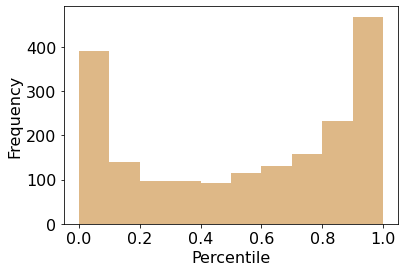

In [121]:
plt.rcParams.update({"font.size": 16})
counts, bins, hist_plot= plt.hist(percentile_df['percentile'], bins=np.linspace(0, 1, 11), color="burlywood")
plt.xlabel("Percentile")
plt.ylabel("Frequency")

,avg_percentile,count
nsfw,0.068155,15
politics,0.212672,33
technology_general,0.358359,5
general,0.389927,16
other,0.415956,129
locations,0.435806,102
discussion,0.461802,102
education,0.463833,79
lifestyle,0.471414,141
animals,0.486501,5


## Follow up analyses

In [65]:
from src.utils.topic_utils import *
import re

In [84]:
subreddits_of_interest = pd.read_csv("/u/jai/efficiency/data/cogsci_2024_communities.txt", header=None)[0].tolist()
subreddits_of_interest = list(map(lambda x: x.lower(), subreddits_of_interest))
subreddit_to_subtopic, topic_to_subtopic = generate_main_topic_mappings()
subreddit_to_subtopic = augment_subtopic_mappings(subreddit_to_subtopic, subreddits_of_interest)
subreddit_to_single_subtopic = select_subtopic_per_subreddit(subreddit_to_subtopic, subreddits_of_interest)
subreddit_to_topic = map_subtopic_to_topic(subreddit_to_single_subtopic, topic_to_subtopic)

100%|██████████| 2936/2936 [00:00<00:00, 253739.32it/s]

sourced from: https://www.reddit.com/r/listofsubreddits/wiki/listofsubreddits/?show_source
---
for more advice/assistance subreddits, [see here!](http://www.reddit.com/r/listofsubreddits/wiki/advice)
---
## general
for more, see [the wiki compiled](http://www.reddit.com/r/historynetwork/wiki/listofhistorysubreddits) by /r/historynetwork!
note: many of those subreddits are inactive.
---
## [**video games**](https://www.reddit.com/r/listofsubreddits/wiki/games50k)
*the above is the complete list of every video game subreddit with currently 50k or more subscribers!*
[for other sci-fi subreddits, see here!](https://www.reddit.com/r/spacegeek/wiki/relatedsubreddits)
###  *4chan*
much more \[here\]\(http://www.reddit.com/r/listentothis/about/sidebar\) from the sidebar of /r/listentothis!
see especially \[the fire hose\]\(http://www.reddit.com/user/evilnight/m/thefirehose\) curated by /u/evilnight. all subreddits are active!
[sports subreddits!](http://www.reddit.com/r/listofsubreddits/wiki/s

In [85]:
sub_to_topic_df = pd.DataFrame.from_dict(subreddit_to_topic, orient='index')
sub_to_topic_df.columns = ['topic']

In [86]:
nsfw_subreddits = sub_to_topic_df[sub_to_topic_df['topic'] == 'nsfw'].index.tolist()
sports_subreddits = sub_to_topic_df[sub_to_topic_df['topic'] == 'sports'].index.tolist()
gaming_subreddits = sub_to_topic_df[sub_to_topic_df['topic'] == 'video_games'].index.tolist()

In [91]:
percentile_topic_df = sub_to_topic_df.join(all_percentile_df)
percentile_agg = percentile_topic_df.groupby("topic").mean().sort_values(by='percentile')
topic_counts = percentile_topic_df.groupby("topic").count().sort_values(by='percentile')
total = pd.concat([percentile_agg, topic_counts['percentile']], axis=1)
total.columns = ['avg_percentile', 'avg_controlled_percentile', 'avg_diff', 'count']

In [137]:
size_info = pd.read_csv("/u/jai/efficiency/data/cogsci_2024_social_network_features.csv",  index_col=0)
social_network_info = pd.read_csv("/u/jai/efficiency/data/final_cogsci_2024_social_network_features.csv",  index_col=0)
social_network_info['size'] = size_info['size']
social_network_info.index = social_network_info.index.str.lower()
full_social_df = social_network_info.join(percentile_topic_df)


In [141]:
full_social_df.groupby("topic").mean().sort_values(by='size')

,size,loyalty,density,percentile,controlled_percentile,diff
topic,,,,,,
no_topic_assigned,11894.587302,0.074974,0.003312,0.350812,0.394578,0.043766
locations,22299.323529,0.062021,0.002809,0.286847,0.299308,0.012462
sports,24816.056604,0.091674,0.003714,0.436735,0.501399,0.064664
hobbies,44089.922330,0.030104,0.000738,0.382374,0.441939,0.059565
education,46393.670886,0.025660,0.000887,0.337581,0.367319,0.029739
nsfw,47609.266667,0.053655,0.000900,0.499748,0.659140,0.159392
technology,48447.000000,0.031281,0.000795,0.351374,0.400022,0.048648
lifestyle,51200.297872,0.033549,0.000743,0.370236,0.421706,0.051470
animals,54232.800000,0.013453,0.000343,0.344625,0.384603,0.039978


In [145]:
full_social_df.corr("spearman")

,size,loyalty,density,percentile,controlled_percentile,diff
size,1.000000,-0.460333,-0.877590,-0.179276,-0.174863,-0.153668
loyalty,-0.460333,1.000000,0.769301,0.203584,0.218073,0.281145
density,-0.877590,0.769301,1.000000,0.224276,0.223200,0.215606
percentile,-0.179276,0.203584,0.224276,1.000000,0.995184,0.875073
controlled_percentile,-0.174863,0.218073,0.223200,0.995184,1.000000,0.912897
diff,-0.153668,0.281145,0.215606,0.875073,0.912897,1.000000


# Old Testing Components

## Testing Hypothetical Parameters

In [ ]:

# parameters_to_hyps = defaultdict(defaultdict)
# parameters_to_efficiency_df = defaultdict(defaultdict)
# for system_mean in [0, 1e-6, 4e-5]:
#      for min_variance in [1e-5, 4e-5]:
#         system_mean = float(system_mean)
#         min_variance = float(min_variance)
#         base_systems = generate_min_complexity_hypotheticals(min_variance, 0.04, 10, system_mean, 10)
#         parameters_to_hyps[system_mean][min_variance] = base_systems

#         hyp_com_to_encoder = {hyp.id: pd.DataFrame(hyp.dist) for hyp in base_systems if np.allclose(hyp.dist.sum(), 243)}
#         efficiency_df = compute_attested_tradeoff_vals(hyp_com_to_encoder,  com_to_needs['askreddit'], GLOBAL_SIMILARITY_MATRIX, complexity_baseline)
#         parameters_to_efficiency_df[system_mean][min_variance] = efficiency_df

# for system_mean in [0, 1e-5, 4e-5]:
#     for min_variance in [1e-5, 4e-5, 1e-4]:
#         print(f"Mean: {system_mean} Variance: {min_variance}")
#         cost = np.round(parameters_to_efficiency_df[system_mean][min_variance].min()['cost'], 2)
#         print(f"Cost: {cost}")
#         # joint_density_plot(parameters_to_efficiency_df[system_mean][min_variance])

## Testing New Hypothetical Generation Method

In [170]:
from src.all_ranks_computation import load_base_systems, swap_wrapper, HypotheticalObj
from src.efficiency import generate_dataframe_mappings

DATA_SUFFIX = 'cogsci_2024'
NUM_QUANTILES = 3
NUM_SITUATIONS = 2**NUM_QUANTILES
VARIANCE = 0.01
SMOOTHING_DELTA = 1e-10

INTENSIFIERS = sorted(load_intensifiers("../data/luo_intensifiers.txt"))
NUM_INTENSIFIERS = len(INTENSIFIERS)

# Takes 4 seconds
GLOBAL_SIMILARITY_MATRIX = generate_referent_similarity(DATA_SUFFIX, VARIANCE, NUM_QUANTILES, None, None)
GLOBAL_VADPF_REPS = Serialization.load_obj(f"semantic_situation_mean_values_{NUM_QUANTILES}_{DATA_SUFFIX}")

_, com_to_encoder, com_to_needs, _ = generate_dataframe_mappings(DATA_SUFFIX, NUM_INTENSIFIERS, SMOOTHING_DELTA, exclude_askreddit=False)


In [187]:
base_systems = load_base_systems()

np.random.seed(42)
swapped_hyps = []
for base_system in tqdm(base_systems):
    num_column_swaps = np.random.choice(11) * 10
    swaps = swap_wrapper(base_system, num_system_swaps=1, num_column_swaps=num_column_swaps, include_base=False)
    swapped_hyps.extend(swaps)

100%|██████████| 10000/10000 [00:28<00:00, 355.60it/s]


In [188]:
hyp_com_to_encoder = {hyp.id: pd.DataFrame(hyp.dist) for hyp in swapped_hyps}
complexity_baseline = com_to_encoder['askreddit'] * com_to_needs['askreddit']
sorted_complexity_baseline = complexity_baseline[complexity_baseline.columns[complexity_baseline.sum(axis=0).argsort()]]

hypothetical_df = compute_attested_tradeoff_vals(hyp_com_to_encoder, com_to_needs['askreddit'], GLOBAL_SIMILARITY_MATRIX, sorted_complexity_baseline, 'askreddit')

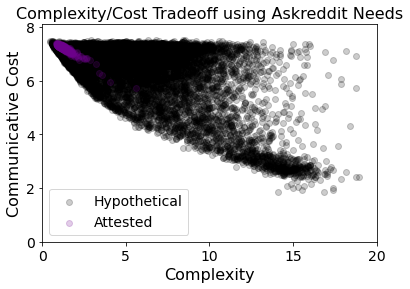

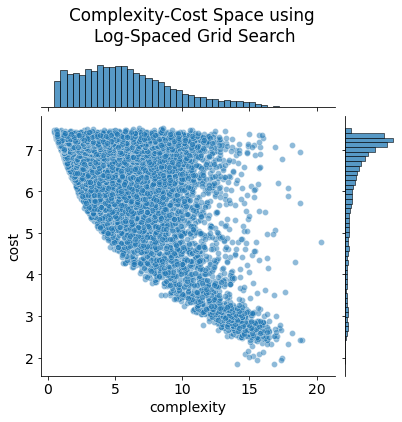

<Figure size 432x288 with 0 Axes>

In [189]:
fake_data = {"askreddit": {"attested": all_data['askreddit']['attested'], "hypothetical": {"rank_df": hypothetical_df, "color": "black"}}}
visualize_single_need(fake_data, "askreddit")
joint_density_plot(hypothetical_df)